# Introducing the gosduma7 Dataset

In [1]:
# Some initialization magic
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import collections

# Let's load up the data
import json

with open("scrapyproject/results.json") as fin:
    lines = [json.loads(line) for line in fin]

In [2]:
# Here's what it looks like. Each line corresponds to a single electorate.
lines[0]["electorate"]

'Республика Адыгея (Адыгея) - Адыгейский'

In [3]:
# For each we keep the votes broken down by party, and further broken down by the polling station
# Thus, for the Adygea electorate, the Rodina party achieved 2065 votes across the 9 polling stations.
lines[0]["votes"][0]

{'stations': [{'name': 'Адыгейская', 'value': 9.0},
  {'name': 'Гиагинская', 'value': 135.0},
  {'name': 'Кошехабльская', 'value': 137.0},
  {'name': 'Красногвардейская', 'value': 59.0},
  {'name': 'Майкопская', 'value': 327.0},
  {'name': 'Майкопская городская', 'value': 1105.0},
  {'name': 'Тахтамукайская', 'value': 268.0},
  {'name': 'Теучежская', 'value': 6.0},
  {'name': 'Шовгеновская', 'value': 19.0}],
 'subtitle': '1. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"',
 'total_value': 2065.0}

In [4]:
# We also keep the overall stats for the electorate.
# Thus, the Adygea electorate consisted of 339685 eligible voters across the 9 polling stations.
lines[0]["stats"][0]

{'stations': [{'name': 'Адыгейская', 'value': 11932.0},
  {'name': 'Гиагинская', 'value': 24743.0},
  {'name': 'Кошехабльская', 'value': 22779.0},
  {'name': 'Красногвардейская', 'value': 21925.0},
  {'name': 'Майкопская', 'value': 46456.0},
  {'name': 'Майкопская городская', 'value': 130529.0},
  {'name': 'Тахтамукайская', 'value': 55175.0},
  {'name': 'Теучежская', 'value': 13768.0},
  {'name': 'Шовгеновская', 'value': 12378.0}],
 'subtitle': 'Число избирателей, внесенных в список избирателей на момент окончания голосования',
 'total_value': 339685.0}

# A More Workable Data Format

In [5]:
# The order of statistics and parties is the same across the entire dataset,
# so there's no real need of repeating it everywhere.
STATISTICS = [stat["subtitle"] for stat in lines[0]["stats"]]
PARTIES = [party["subtitle"] for party in lines[0]["votes"]]

print("\n".join(str(x) for x in list(enumerate(STATISTICS))))
print()
print("\n".join(str(x) for x in list(enumerate(PARTIES))))

(0, 'Число избирателей, внесенных в список избирателей на момент окончания голосования')
(1, 'Число избирательных бюллетеней, полученных участковой избирательной комиссией')
(2, 'Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно')
(3, 'Число избирательных бюллетеней, выданных в помещении для голосования в день голосования')
(4, 'Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования')
(5, 'Число погашенных избирательных бюллетеней')
(6, 'Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования')
(7, 'Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования')
(8, 'Число недействительных избирательных бюллетеней')
(9, 'Число действительных избирательных бюллетеней')
(10, 'Число открепительных удостоверений, полученных участковой избирательной комиссией')
(11, 'Число открепительных удостоверений, выданных на избирательном участке до дня голосования')
(12, 'Число избирателей, п

In [6]:
# Let's get things into a more workable format.


def tabulate(elec):
    station_names = [st["name"] for st in elec["stats"][0]["stations"]]
    
    # Each row of the stats matrix is a statistic (number of voters, etc).
    # The order of statistics is the same as STATISTICS.
    # The first column is the total value across all stations.
    # The remaining columns contain the value for each individual station,
    # appearing in the order of station_names.
    stats = []
    for statistic in elec["stats"]:
        row_of_values = [statistic["total_value"]]
        for station in statistic["stations"]:
            row_of_values.append(station["value"])
        stats.append(row_of_values)
        
        assert row_of_values[0] == sum(row_of_values[1:])
    
    # Each row of the votes matrix shows votes for a particular party.
    # The order the parties is the same as PARTIES.
    # The first column is the total value across all stations.
    # The remaining columns contain the value for each individual station,
    # appearing in the order of station_names.
    votes = []
    for party_votes in elec["votes"]:
        row_of_values = [party_votes["total_value"]]
        for station in party_votes["stations"]:
            row_of_values.append(station["value"])
        votes.append(row_of_values)
        
        assert row_of_values[0] == sum(row_of_values[1:])
    
    return {
        "electorate_name": elec["electorate"],
        "station_names": station_names,
        "stats": stats,
        "votes": votes
    }

tabulated_electorates = [tabulate(e) for e in lines]

# Checking the Dataset

Expected values from [here](http://www.vybory.izbirkom.ru/region/region/izbirkom?action=show&root=1&tvd=100100067795854&vrn=100100067795849&region=0&global=1&sub_region=0&prver=0&pronetvd=0&vibid=100100067795854&type=233).

In [7]:
expected = [
    ('1. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"',   792226, 1.51),
    ('2. Политическая партия КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ',    1192595, 2.27),
    ('3. Политическая партия "Российская партия пенсионеров за справедливость"',    910848, 1.73),
    ('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"',    28523828, 54.19),
    ('5. Политическая партия "Российская экологическая партия "Зеленые"',   399429, 0.76),
    ('6. Политическая партия "Гражданская Платформа"',  115433, 0.22),
    ('7. Политическая партия ЛДПР - Либерально-демократическая партия России',  6917063, 13.14),
    ('8. Политическая партия "Партия народной свободы" (ПАРНАС)',   384675, 0.73),
    ('9. Всероссийская политическая партия "ПАРТИЯ РОСТА"', 679030, 1.29),
    ('10. Общественная организация Всероссийская политическая партия "Гражданская Сила"',   73971, 0.14),
    ('11. Политическая партия "Российская объединенная демократическая партия "ЯБЛОКО"',    1051335, 1.99),
    ('12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"',  7019752, 13.34),
    ('13. Политическая партия "ПАТРИОТЫ РОССИИ"',   310015, 0.59),
    ('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ', 3279053, 6.23),
]

stat_idx = STATISTICS.index('Число действительных избирательных бюллетеней')
total_votes = sum(e["stats"][stat_idx][0] for e in tabulated_electorates)
for party_idx, party_name in enumerate(PARTIES):
    for_this_party = sum(e["votes"][party_idx][0] for e in tabulated_electorates)
    percentage = for_this_party * 100 / total_votes
    exp_name, exp_for_this, exp_percentage = expected[party_idx]
    
    assert party_name == exp_name
    
    print(
        "{:s} {:.0f} ({:.0f}) {:.2f} ({:.2f})".format(
            party_name, for_this_party, exp_for_this - for_this_party,
            percentage, exp_percentage - percentage
        )
    )

1. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА" 791547 (679) 1.53 (-0.02)
2. Политическая партия КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ 1192376 (219) 2.31 (-0.04)
3. Политическая партия "Российская партия пенсионеров за справедливость" 910499 (349) 1.76 (-0.03)
4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ" 28509106 (14722) 55.22 (-1.03)
5. Политическая партия "Российская экологическая партия "Зеленые" 399304 (125) 0.77 (-0.01)
6. Политическая партия "Гражданская Платформа" 115439 (-6) 0.22 (-0.00)
7. Политическая партия ЛДПР - Либерально-демократическая партия России 6915060 (2003) 13.39 (-0.25)
8. Политическая партия "Партия народной свободы" (ПАРНАС) 384415 (260) 0.74 (-0.01)
9. Всероссийская политическая партия "ПАРТИЯ РОСТА" 678778 (252) 1.31 (-0.02)
10. Общественная организация Всероссийская политическая партия "Гражданская Сила" 73972 (-1) 0.14 (-0.00)
11. Политическая партия "Российская объединенная демократическая партия "ЯБЛОКО" 1050652 (683) 2.04 (-0.05)
12. Политичес

In [8]:
len(tabulated_electorates)

225

In [9]:
sum(len(e["station_names"]) for e in tabulated_electorates)

2820

# Recreating the Graph from [Slon.ru](https://tjournal.ru/34502-zhurnalisti-slonru-matematicheski-obnaruzhili-priznaki-masshtabnih-falsifikacii-na-viborah-v-gosdumu)
The X-axis shows the percentage of votes gained, from 0.00 to 1.00. The Y-axis shows the total votes for that party across all polling stations with the specified percentage of votes for a particular party.

In [10]:
import scipy.signal


def station_generator(elec):
    """Yield the stations in this electorate, along with the attributes that we will be plotting."""
    eligible_voters = elec["stats"][STATISTICS.index('Число избирателей, внесенных в список избирателей на момент окончания голосования')]
    valid_ballots = elec["stats"][STATISTICS.index('Число действительных избирательных бюллетеней')]

    # Calculate the turnout as the number of valid ballots out of the total number of voters for that station
    # One-based indexing because the first column is the total across all stations.
    # The votes array for each station contain the number of votes counted for each party, in order of PARTIES.
    # The fraction array contains the proportion of votes for each party, in the same order.
    for st_idx, st_name in enumerate(elec["station_names"], 1):
        station = {
            "electorate": elec["electorate_name"],
            "station": st_name,
            "fraction": [],
            "votes": [],
            "turnout": valid_ballots[st_idx] / eligible_voters[st_idx]
        }
        for party_idx, _ in enumerate(PARTIES):
            raw_votes = elec["votes"][party_idx][st_idx]
            station["votes"].append(raw_votes)
            station["fraction"].append(raw_votes / valid_ballots[st_idx])

        yield station

        
def round_nearest(x, a=0.002):
    """Round the x-value to the nearest a-value."""
    # http://stackoverflow.com/questions/28425705/python-rounding-a-floating-point-number-to-nearest-0-05
    return round(x / a) * a


def bin_by(stations, key_function):
    """Bin each polling station by the turnout at the station."""
    bins = collections.defaultdict(list)
    for station in stations:
        bins[round_nearest(key_function(station))].append(station)
    return sorted(bins.items())


def box_filter(y, box_pts=9):
    """Smoooth the y-signal using a regular box filter of the specified width."""
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

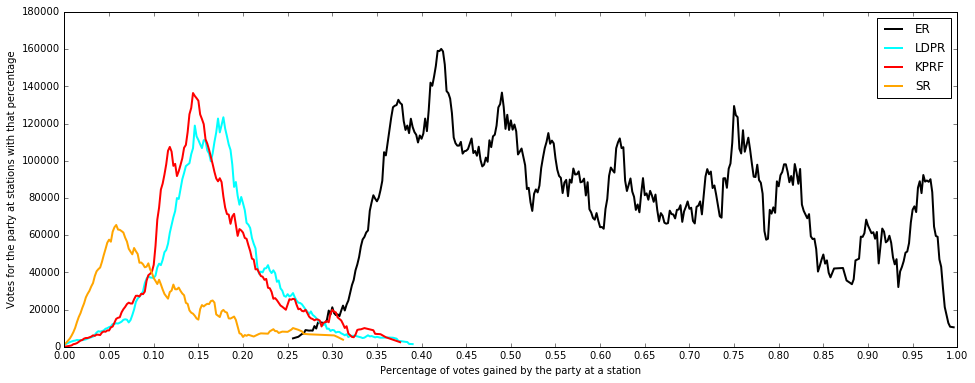

In [11]:
def plot(full_party_name, ascii_name, color, linewidth=2):
    stations = []
    for electorate in tabulated_electorates:
        stations.extend(station_generator(electorate))
        
    party_idx = PARTIES.index(full_party_name)
    bins = bin_by(stations, lambda station: station["fraction"][party_idx])
    
    x = [val for (val, _) in bins]
    y = [sum(st["votes"][party_idx] for st in stations) for (_, stations) in bins]
    y = box_filter(y)
    
    plt.plot(x, y, linewidth=linewidth, label=ascii_name, color=color)

plt.figure(figsize=(16, 6))

plot('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"', "ER", "black")
plot('7. Политическая партия ЛДПР - Либерально-демократическая партия России', "LDPR", "cyan")
plot('12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"', "KPRF", "red")
plot('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ', "SR", "orange")

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Votes for the party at stations with that percentage")
plt.xlabel("Percentage of votes gained by the party at a station")

plt.legend()

print()

# Let's Try the Voter Turnout Graph
The X-axis shows the turnout percentage, calculated as the number of valid ballots divided by the total number of eligible voters. The Y-axis shows the total number of votes for each party for each polling station with the specified turnout.

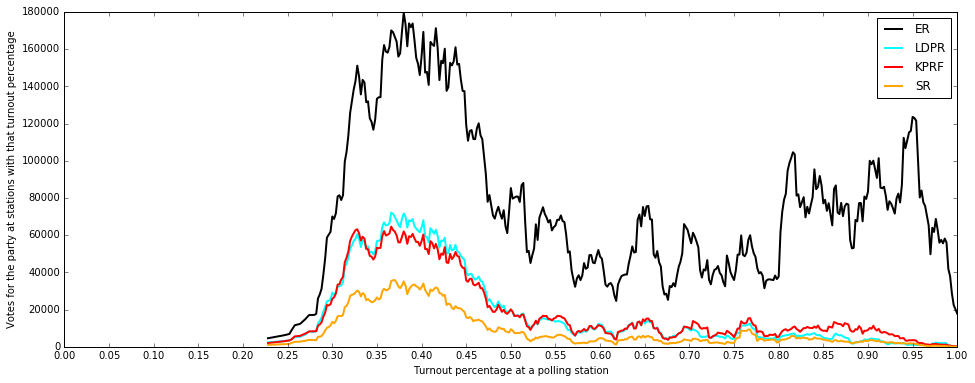

In [12]:
def plot(full_party_name, ascii_name, color, linewidth=2):
    stations = []
    for electorate in tabulated_electorates:
        stations.extend(station_generator(electorate))
        
    party_idx = PARTIES.index(full_party_name)
    bins = bin_by(stations, lambda station: station["turnout"])
    
    x = [val for (val, _) in bins]
    y = [sum(st["votes"][party_idx] for st in stations) for (_, stations) in bins]
    y = box_filter(y)
    
    plt.plot(x, y, linewidth=linewidth, label=ascii_name, color=color)


plt.figure(figsize=(16, 6))

plot('4. Всероссийская политическая партия "ЕДИНАЯ РОССИЯ"', "ER", "black")
plot('7. Политическая партия ЛДПР - Либерально-демократическая партия России', "LDPR", "cyan")
plot('12. Политическая партия "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"', "KPRF", "red")
plot('14. Политическая партия СПРАВЕДЛИВАЯ РОССИЯ', "SR", "orange")

plt.xticks(np.arange(0, 1.05, 0.05))
plt.ylabel("Votes for the party at stations with that turnout percentage")
plt.xlabel("Turnout percentage at a polling station")

plt.legend()

print()